In [ ]:
import pygame as p, random as r, time, numpy as np
from IPython.display import clear_output
import neat
p.init()
d_w = 800            # Display width
d_h = 600            # Display height
gap = 200            # Size of gap bird flies through
distance = 300       # Distance between pipes. higher value = lower distance
speed = 8            # Speed the bird moves horizontally
jump_height = 19     # How much upwards velocity the bird gets upon jumping
gravity = 1.25       # How fast upwards velocity decreases

In [ ]:
'''
Game classes
'''
class Bird():
    def __init__(self, filename = None):
        self.reward = 0
        self.image = None
        if filename: # Makes an image for the bird
            self.image = p.image.load(filename)
            self.image = p.transform.scale(self.image, (60, 42))
            self.orig_image = p.image.load(filename)
            self.orig_image = p.transform.scale(self.orig_image, (60, 42))
        self.vel = 0
        self.dead = False
        self.y = r.randint(80, 520)
        self.x = 20
        
    def flap(self):
        self.vel = jump_height
        
    def update(self):
        # Updates game state every time step
        if self.image:
            self.image = p.transform.rotate(self.orig_image, self.vel*3) # Rotate bird slightly when he jumps
        self.y -= self.vel
        self.vel -= gravity
        
        if self.y >= d_h or self.reward > 5000: # Kills the beard if reward is super high to end generation or if bird has hit the ground.
            self.dead = True
            if self.y >= d_h: 
                self.reward -= 2 # Decrease reward by 2 if bird hits the ground
            
        if self.y <= 0: # If the bird touches the ceiling, stop him and decrease his score by 1
            self.y = 0
            self.reward -= 1
                
class Pipe():
    def __init__(self, filename = None):
        self.top = r.randint(50, d_h-gap-50) # bottom of top of pipe y value
        self.bottom = self.top + gap         # top of bottom of pipe y value
        self.bottom_image = p.surfarray.make_surface(np.zeros((65, d_h-self.bottom)))
        self.top_image = p.surfarray.make_surface(np.zeros((65, self.top)))
        self.x = d_w
        self.seen = False
    def update(self, bird_x, bird_y):
        # Updates game state every time step. Returns whether bird is dead
        self.x -= speed # Makes pipe move left
        if ((bird_y + 5 < self.top or bird_y + 42 > self.bottom) and abs(bird_x + 30 - self.x - 33) < (30+33)):  # Checks if bird is in contact with pipe. Returns True if bird should die.
            return True
        return False
    
    def see(self, current_reward):
        # Looks at pipes. If there are any new pipes, increase reward by 1.
        if not self.seen:
            self.seen = True
            current_reward += 1
        return current_reward

In [ ]:
'''
Setting up game
'''

background = p.image.load('background.png')
background = p.transform.scale(background, (d_w, d_h))
def run_game(network, show, prob = False):
    '''
    show: Whether to show each genome play the game. Takes orders of magnitute longer to train, but you get to see it work
    prob: If True, the output of the neural network is a sampled probability of jumping. If False, the bird jumps if the output is over 0.5
    '''
    if show: # Setting up display
        clock = p.time.Clock()
        gameDisplay = p.display.set_mode((d_w, d_h), )
        p.display.set_caption('Flappy Bird')
        background = p.image.load('background.png')
        background = p.transform.scale(background, (d_w, d_h))
    bird = Bird()
    if show:
        bird = Bird('flapbird.png')
        
    pipes = [Pipe()]
    in_net = None 
    
    while not bird.dead:
        if len(pipes) > 1: # Feeds in the most relevant pipe details to the network
            if pipes[-2].x < bird.x-60:
                in_net = [pipes[-1].x - bird.x, bird.y, bird.vel, pipes[-1].top, pipes[-1].bottom]
            else:
                in_net = [pipes[-2].x - bird.x, bird.y, bird.vel, pipes[-2].top, pipes[-2].bottom]
        else:
            in_net = [pipes[-1].x - bird.x, bird.y, bird.vel, pipes[-1].top,  pipes[-1].bottom]
            
        out = network.activate(in_net)[0] # Whether to jump
        if prob:
            if np.random.uniform() < out[0]:
                bird.flap()
        else:
            if out > 0.5:
                bird.flap()
        
        bird.update()
        
        # Checks if bird is in contact with pipes
        for pipe in pipes[-2:]:
            if pipe.update(bird.x, bird.y):
                bird.dead = True
                break
        
        # Deletes pipes out of the screen
        pipes = pipes[-2:]
        if pipes[-1].x <= distance:
            pipes.append(Pipe()) # Adds new pipe
            
        # Shows birds in a window
        if show:
            gameDisplay.blit(background, (0,0))
            gameDisplay.blit(bird.image, (bird.x, bird.y))

            for pipe in pipes:
                gameDisplay.blit(pipe.bottom_image, (pipe.x, pipe.bottom))
                gameDisplay.blit(pipe.top_image, (pipe.x, 0))
        
            p.display.update()
            clock.tick(60)
        
        # Adds reward for new pipes
        for pipe in pipes:
            bird.reward = pipe.see(bird.reward)
            
    return bird.reward

In [ ]:
'''
Setting up NEAT
'''
config = neat.config.Config(neat.genome.DefaultGenome,
                           neat.reproduction.DefaultReproduction,
                           neat.species.DefaultSpeciesSet,
                           neat.stagnation.DefaultStagnation,
                           'config.txt')

population = neat.population.Population(config, )
population.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
population.add_reporter(stats)

In [ ]:
'''
Function for evaluating fitness of each genome
'''
def eval_genome(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        reward = run_game(net, True)
        genome.fitness = reward
        clear_output(True)

In [ ]:
winner = population.run(eval_genome, ) # KeyboardInterrupt the program when you want to end training

In [ ]:
p.quit() # Closes any game windows

In [ ]:
winner = population.run(eval_genome, 0) # Without running a generation, assign the best genome
win_net = neat.nn.FeedForwardNetwork.create(winner, config) # Makes a neural network of the winning genome

In [ ]:
run_game(win_net, show = True, prob = False) # Runs the game with the best bird.
p.quit()

In [ ]:
'''
Copy pasted visualize.py from GitHub of NEAT guys
'''

import copy
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np


def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    #plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    """ Plots the trains for a single spiking neuron. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    t_values = [t for t, I, v, u in spikes]
    v_values = [v for t, I, v, u in spikes]
    u_values = [u for t, I, v, u in spikes]
    I_values = [I for t, I, v, u in spikes]

    fig = plt.figure()
    plt.subplot(3, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(3, 1, 2)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")

    plt.subplot(3, 1, 3)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T

    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    if prune_unused:
        connections = set()
        for cg in genome.connections.values():
            if cg.enabled or show_disabled:
                connections.add(cg.key)

        used_nodes = copy.copy(outputs)
        pending = copy.copy(outputs)
        while pending:
            new_pending = set()
            for a, b in connections:
                if b in pending and a not in used_nodes:
                    new_pending.add(a)
                    used_nodes.add(a)
            pending = new_pending
    else:
        used_nodes = set(genome.nodes.keys())

    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled', 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            #if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

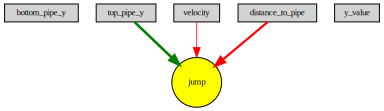

In [ ]:
# Drawing winning network
draw_net(config, winner, show_disabled=False, node_colors = {0:'yellow'}, node_names = {0:'jump', -1:'bottom_pipe_y', -2:'top_pipe_y', -3:'velocity', -4:'y_value', -5:'distance_to_pipe'})

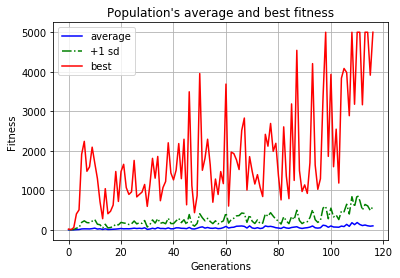

In [ ]:
# Population statistics
plot_stats(stats, view = True, filename='speciation')

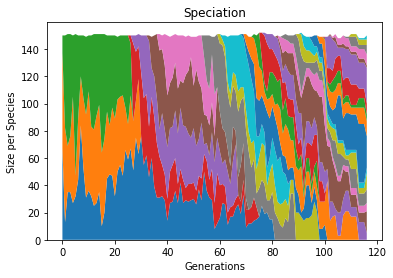

In [ ]:
# Species distribution over generations
plot_species(stats, True)